# Team Members:
* 20521493 - Bùi Tuấn Kiệt
* 20521482 - Trần Đình Khôi
* 20521119 - Vũ Quốc Thái Bình
* 20520944 - Tôn Anh Trúc

Link to data
https://drive.google.com/drive/folders/1ja3B2OMVEm-NkF6tdqK2WSl_CAY7L-A5?usp=sharing

In [ ]:
%matplotlib inline

import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")


from sklearn import tree
from sklearn.linear_model import Ridge, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PythonPrograming/Dataset/flights.csv')

In [ ]:
airlines_names = pd.read_csv('/content/drive/MyDrive/PythonPrograming/Dataset/airlines.csv')
airports = pd.read_csv('/content/drive/MyDrive/PythonPrograming/Dataset/airports.csv')

# Preprocessing data

Contribute YEAR, MONTH, DAY to DATE

In [ ]:
df = df[df['MONTH'] == 1]

In [ ]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [ ]:
df['DATE']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2015-01-01
4        2015-01-01
            ...    
469963   2015-01-31
469964   2015-01-31
469965   2015-01-31
469966   2015-01-31
469967   2015-01-31
Name: DATE, Length: 469968, dtype: datetime64[ns]

In [ ]:
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [ ]:
#Datatime format
def create_flight_time(df, col):
    liste = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

Convert datatime

In [ ]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


** Comment: DEPARTURE_TIME and ARRIVAL_TIME may be not useful to data frame because two attributes DEPARTURE_DELAY and ARRIVAL_DELAY (CHƯA XONG) **

## Những cột cần loại bỏ

In [ ]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR',
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


# Check missing data in data frame

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [ ]:
df.dropna(inplace = True)

# Comparing airlines

In [ ]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [ ]:
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


# Graph 1

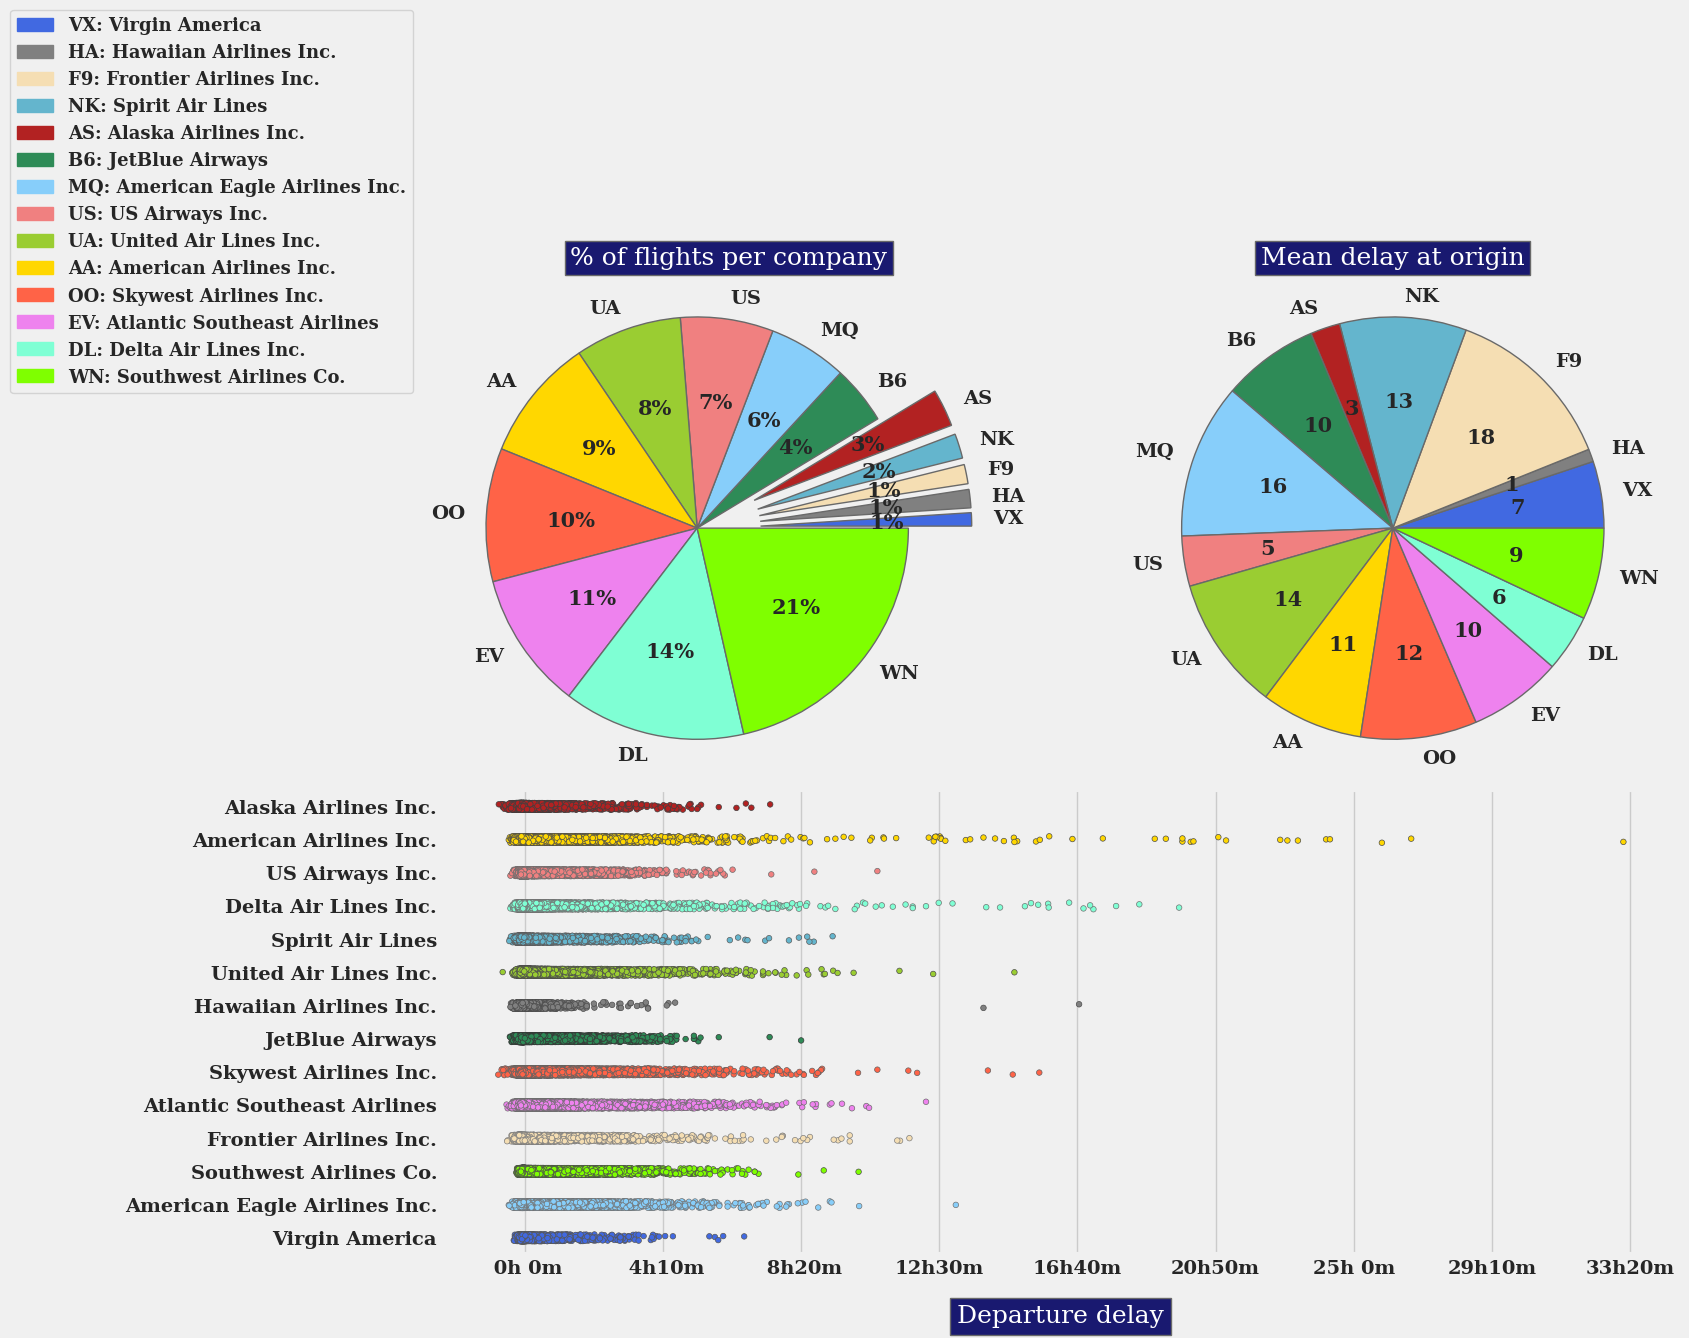

In [ ]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,:])
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)):
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18,y=1.05)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18,y=1.05)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)
plt.savefig("fig2.png")
plt.show();

# Graph 2

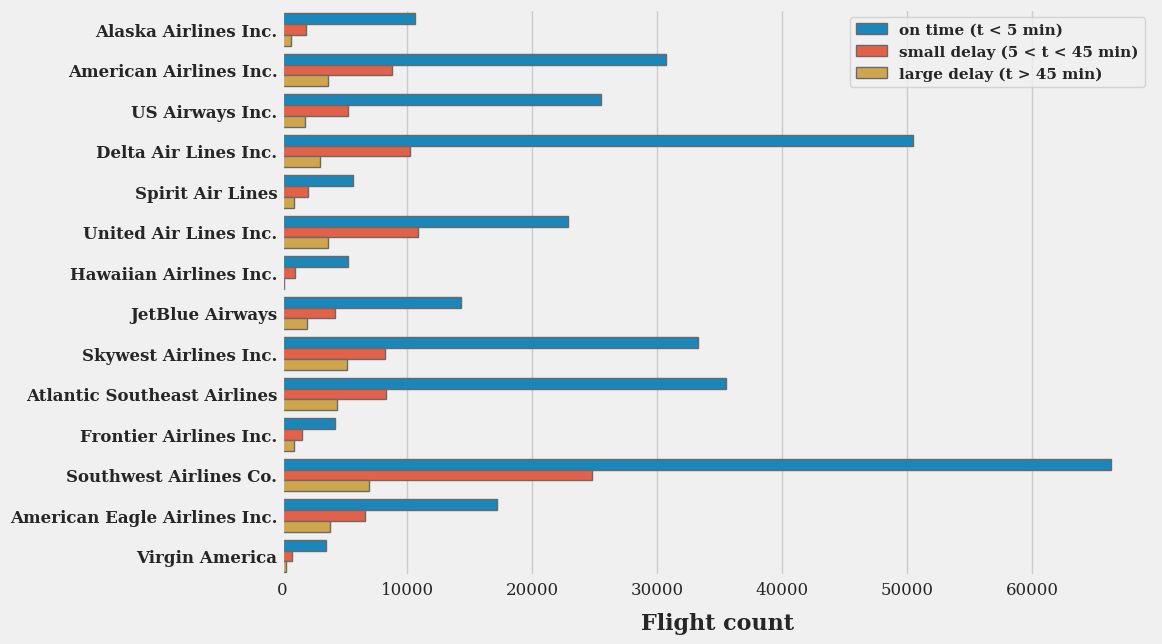

In [ ]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.savefig("fig4.png")
plt.show();

# Graph 3

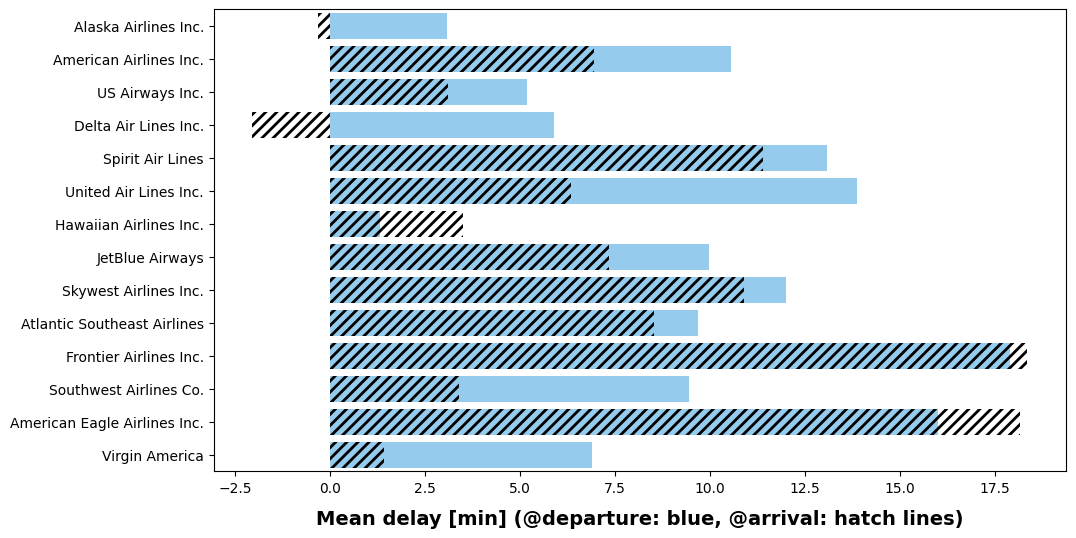

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10)
plt.show();

# Graph 4

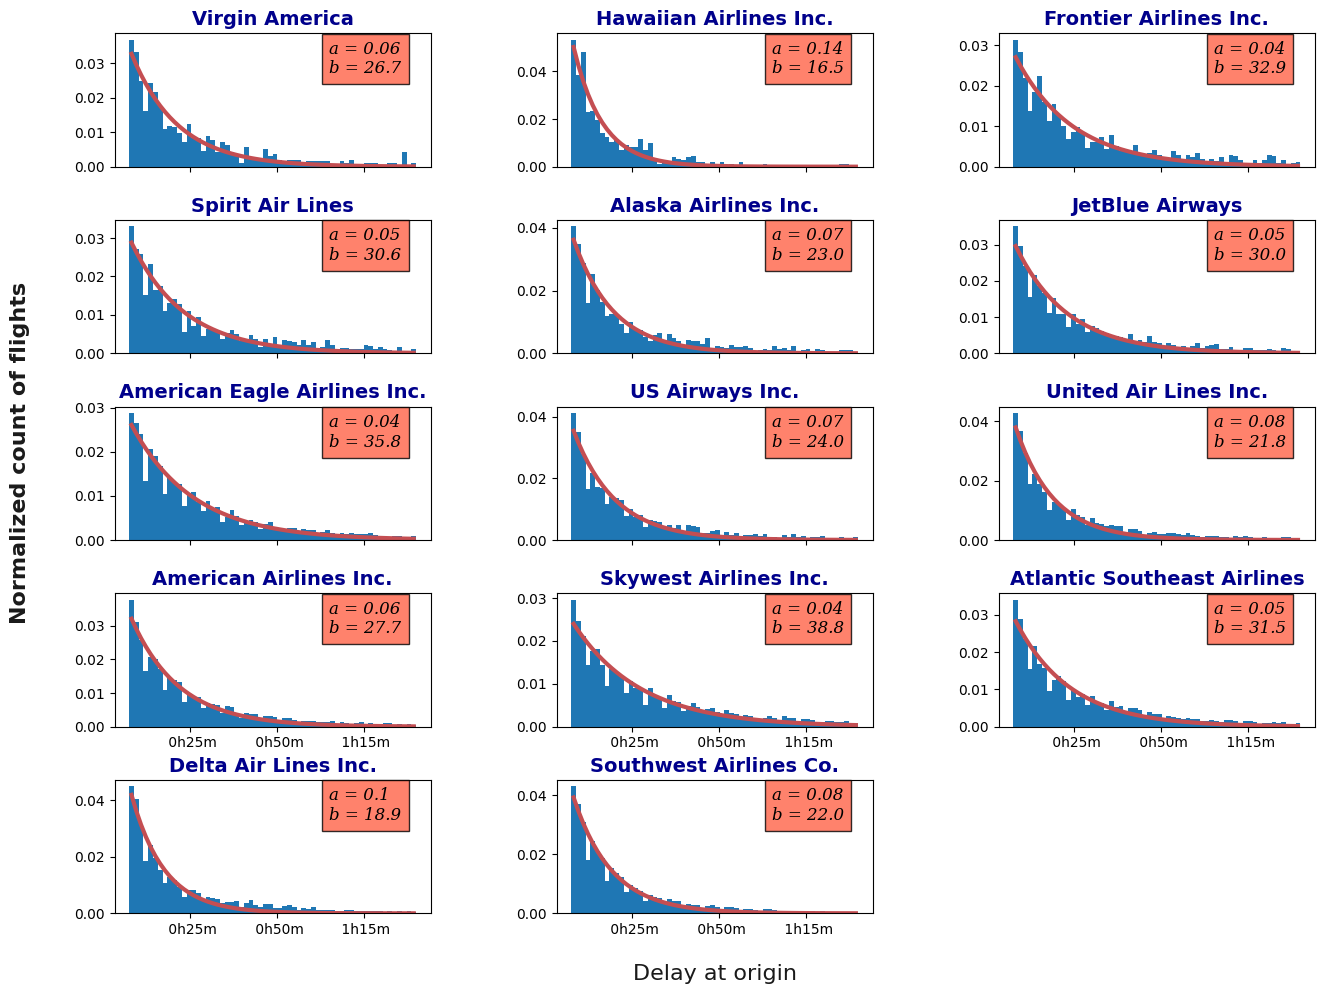

In [ ]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)

#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(15,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels
    if i == 4:
        ax.text(-0.3,-2,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes,weight='bold')
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='serif',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.tight_layout()
plt.show();

## Graph 4.1

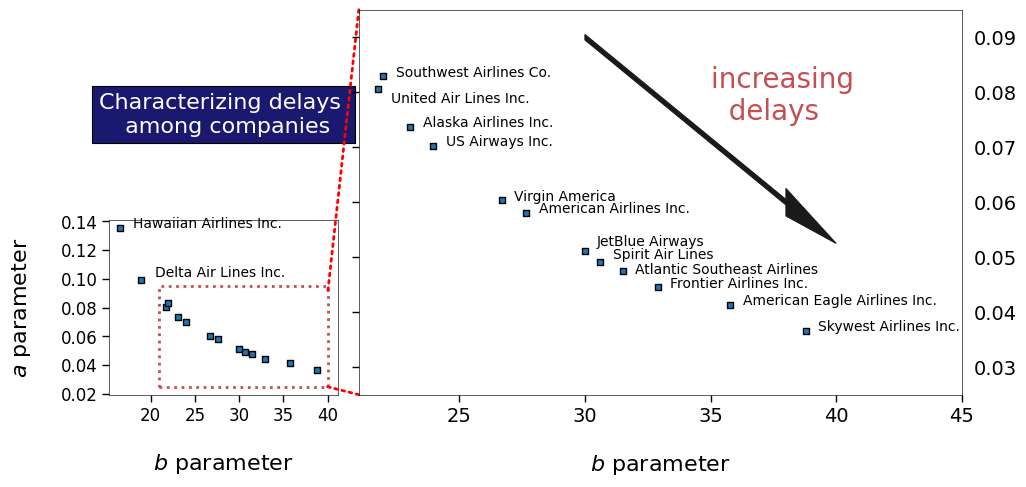

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = 1)
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
#Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
#plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
#Create a Rectangle
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)

# #_______________________________________________
# # 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = 1)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
# #________________
# # Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
# #____________________________
# # Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# # position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
# #________________________
# # plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
# #--------------------------------
plt.show()

# Predicting flight delays

In [ ]:
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0,0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0,0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0,0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
469963,B6,JFK,BQN,2015-01-31 23:59:00,23:59:00,0.0,04:40:00,04:19:00,-21.0,221.0,200.0,0
469964,DL,SEA,DTW,2015-01-31 23:59:00,23:59:00,0.0,07:11:00,06:58:00,-13.0,252.0,239.0,0
469965,F9,DEN,TPA,2015-01-31 23:59:00,00:02:00,3.0,05:11:00,05:34:00,23.0,192.0,212.0,0
469966,F9,DEN,ATL,2015-01-31 23:59:00,23:59:00,0.0,04:41:00,05:10:00,29.0,162.0,191.0,0


# Model: Accounting for destination

In [ ]:
def create_df(df_train):
    df2 = df[['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)

    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrive'] = df2['SCHEDULED_ARRIVAL'].apply(fct)

    df3 = df2.groupby(['heure_depart', 'heure_arrive', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [ ]:
df3 = create_df(df)
df3['Delay'] = (df3['DEPARTURE_DELAY'] > 5).astype(int)
df3

,heure_depart,heure_arrive,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday,Delay
0,300,16140,ANC,-4.500000,3.000000,0
1,300,16200,ANC,-3.166667,3.500000,0
2,300,16620,ANC,-15.000000,6.000000,0
3,300,17640,LAX,0.041667,3.000000,0
4,300,17700,LAX,5.500000,3.750000,1
...,...,...,...,...,...,...
52041,86340,25680,ANC,4.160000,3.120000,0
52042,86340,25860,SEA,-1.625000,4.500000,0
52043,86340,27240,HNL,-2.000000,0.000000,0
52044,86340,28140,LAS,7.666667,3.333333,1


In [ ]:
df3['Delay'].value_counts()

0    33777
1    18269
Name: Delay, dtype: int64

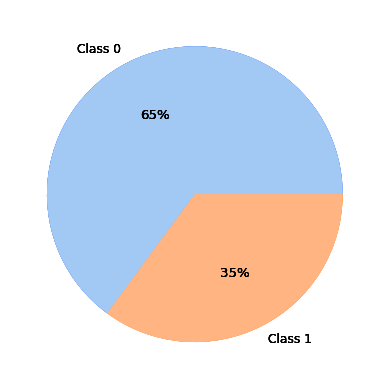

In [ ]:
data = df3['Delay'].value_counts()
keys = ['Class 0', 'Class 1']

palette_color = sns.color_palette('pastel')[0:2]

plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.show()

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
X = np.array(df3[['heure_depart', 'heure_arrive']])

X = np.hstack((onehot_encoded, X))
Y = np.array(df3['Delay'])
Y = Y.reshape(len(Y), 1)

## **Optimizer**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

class Optimizer:
    def __init__(self, model, X_train, X_test, Y_train, Y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.clf = None
        self.space = None
        self.trials = Trials()

    def get_space(self):
        if self.model == 'Knn':
            self.space = {
                'n_neighbors': hp.quniform('n_neighbors', 5, 10, 1),
                'weights': hp.choice('weights', ['uniform', 'distance']),
                'metric' : hp.choice('metric', ['minkowski','euclidean','manhattan'])
            }
        elif self.model == 'Dt':
            self.space = {
                'max_depth': hp.quniform('max_depth', 3, 20, 1),
                'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
                'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
                'criterion': hp.choice('criterion', ['gini', 'entropy']),
            }
        elif self.model == 'Rf':
            self.space = {
                'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
                'max_depth': hp.quniform('max_depth', 3, 20, 1),
                'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
                'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
                'criterion': hp.choice('criterion', ['gini', 'entropy']),
            }
        elif self.model == 'XG':
            self.space = {
                'max_depth': hp.quniform("max_depth", 3, 20, 1),
                'gamma': hp.uniform('gamma', 1, 9),
                'reg_alpha': hp.uniform('reg_alpha', 0, 10.),
                'reg_lambda': hp.uniform('reg_lambda', 1, 10.),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
            }

    def get_model(self):
        if self.model == 'Knn':
            self.clf = KNeighborsClassifier(
                n_neighbors=int(self.space['n_neighbors']),
                weights=self.space['weights'],
                metric=self.space['metric' ]
            )
        elif self.model == 'Dt':
            self.clf = DecisionTreeClassifier(
                max_depth=int(self.space['max_depth']),
                min_samples_split=int(self.space['min_samples_split']),
                min_samples_leaf=int(self.space['min_samples_leaf']),
                criterion=self.space['criterion']
            )
        elif self.model == 'Rf':
            self.clf = RandomForestClassifier(
                n_estimators=int(self.space['n_estimators']),
                max_depth=int(self.space['max_depth']),
                min_samples_split=int(self.space['min_samples_split']),
                min_samples_leaf=int(self.space['min_samples_leaf']),
                criterion=self.space['criterion']
            )
        elif self.model == 'XG':
            self.clf = xgb.XGBClassifier(
                n_estimators=int(self.space['n_estimators']),
                max_depth=int(self.space['max_depth']),
                gamma=self.space['gamma'],
                reg_alpha=self.space['reg_alpha'],
                reg_lambda=self.space['reg_lambda'],
                min_child_weight=int(self.space['min_child_weight']),
                colsample_bytree=self.space['colsample_bytree']
            )

    def objective(self, space):
        self.space = space

        self.get_model()
        self.clf.fit(self.X_train, self.Y_train)

        pred = self.clf.predict(self.X_test)
        f1 = f1_score(self.Y_test, pred, average='weighted')

        return {'loss': -f1, 'status': STATUS_OK, 'prediction': pred}

    def search(self):
        self.get_space()
        best_hyperparams = fmin(
            fn=self.objective,
            space=self.space,
            algo=tpe.suggest,
            max_evals=100,
            trials=self.trials
        )

    def get_results(self):
        return self.trials



## **Data Augmentation**

In [ ]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_res, Y_res = ada.fit_resample(X, Y)

In [ ]:
print(len(Y_res[Y_res == 0]))
len(Y_res[Y_res == 1])

33777


34104

## **Train Test Split**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size=0.3, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## **XGBoost**

### Normal

In [ ]:
import time

start_time = time.time()
clf=xgb.XGBClassifier(
                max_depth = 3,
                gamma = 1,
                reg_alpha = 0,
                reg_lambda = 1,
                colsample_bytree = 0.5,
                min_child_weight = 0,
                n_estimators = 100)
# clf=xgb.XGBClassifier()
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
end_time = time.time()
execution_time_normal_xgboost = end_time - start_time
normal_f1_xgboost = f1_score(Y_test, pred, average='weighted')
print ("SCORE:", normal_f1_xgboost)
print("Execution time:", execution_time_normal_xgboost)

In [ ]:
normal_cm_xgboost = metrics.confusion_matrix(Y_test,pred)

plt.figure(figsize=(8,8))
sns.heatmap(normal_cm_xgboost, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'XGBoost Normal F1 Score: {0}'.format(round(normal_f1_xgboost*100,2))
plt.title(title,size=15)
plt.show();

### Optimize

In [ ]:
start_time = time.time()
op_xgboost = Optimizer('XG',X_train,X_test,Y_train,Y_test)
op_xgboost.search()
end_time = time.time()
execution_time_op_xgboost = end_time - start_time

xgboost_results = op_xgboost.get_results()
op_f1_xgboost = next(filter(lambda x: x['loss'] == min(xgboost_results.losses()), xgboost_results.results), None)
print(-op_f1_xgboost["loss"])
print("Execution time:", execution_time_op_xgboost)

In [ ]:
op_cm_xgboost = metrics.confusion_matrix(Y_test,op_f1_xgboost["prediction"])

plt.figure(figsize=(8,8))
sns.heatmap(op_cm_xgboost, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'XGBoost Normal F1 Score: {0}'.format(round(-op_f1_xgboost["loss"]*100,2))
plt.title(title,size=15)
plt.show();

## KNN

### Normal

In [ ]:
import time

start_time = time.time()
clf=KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric='minkowski')
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
end_time = time.time()
execution_time_normal_knn = end_time - start_time
normal_f1_knn = f1_score(Y_test, pred, average='weighted')
print ("SCORE:", normal_f1_knn)
print("Execution time:", execution_time_normal_knn)

In [ ]:
normal_cm_knn = metrics.confusion_matrix(Y_test,pred)

plt.figure(figsize=(8,8))
sns.heatmap(normal_cm_knn, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Knn Normal F1 Score: {0}'.format(round(normal_f1_knn*100,2))
plt.title(title,size=15)
plt.show();

### Optimize

In [ ]:
start_time = time.time()
op_knn = Optimizer('Knn',X_train,X_test,Y_train,Y_test)
op_knn.search()
end_time = time.time()
execution_time_op_knn = end_time - start_time

knn_results = op_knn.get_results()
op_f1_knn = next(filter(lambda x: x['loss'] == min(knn_results.losses()), knn_results.results), None)
print(-op_f1_knn["loss"])
print("Execution time:", execution_time_op_knn)

In [ ]:
op_cm_knn = metrics.confusion_matrix(Y_test,op_f1_knn["prediction"])

plt.figure(figsize=(8,8))
sns.heatmap(op_cm_knn, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Knn Optimize F1 Score: {0}'.format(round(-op_f1_knn["loss"]*100,2))
plt.title(title,size=15)
plt.show();

## Decision Tree

### Normal

In [ ]:
import time

start_time = time.time()
clf=DecisionTreeClassifier(
                max_depth=3,
                min_samples_split=2,
                min_samples_leaf=1,
                criterion='gini'
            )
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
end_time = time.time()
execution_time_normal_dt = end_time - start_time
normal_f1_dt = f1_score(Y_test, pred, average='weighted')
print ("SCORE:", normal_f1_dt)
print("Execution time:", execution_time_normal_dt)

In [ ]:
clf=DecisionTreeClassifier()
clf.get_params()

In [ ]:
normal_cm_dt = metrics.confusion_matrix(Y_test,pred)

plt.figure(figsize=(8,8))
sns.heatmap(normal_cm_dt, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Dt Normal F1 Score: {0}'.format(round(normal_f1_dt*100,2))
plt.title(title,size=15)
plt.show();

### Optimize

In [ ]:
start_time = time.time()
op_dt = Optimizer('Dt',X_train,X_test,Y_train,Y_test)
op_dt.search()
end_time = time.time()
execution_time_op_dt = end_time - start_time

dt_results = op_dt.get_results()
op_f1_dt = next(filter(lambda x: x['loss'] == min(dt_results.losses()), dt_results.results), None)
print(-op_f1_dt["loss"])
print("Execution time:", execution_time_op_dt)

In [ ]:
op_cm_dt = metrics.confusion_matrix(Y_test,op_f1_dt["prediction"])

plt.figure(figsize=(8,8))
sns.heatmap(op_cm_dt, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Dt Optimize F1 Score: {0}'.format(round(-op_f1_dt["loss"]*100,2))
plt.title(title,size=15)
plt.show();

## Random Forest

### Normal

In [ ]:
import time

start_time = time.time()
clf=RandomForestClassifier(
                n_estimators=100,
                max_depth=3,
                min_samples_split=2,
                min_samples_leaf=1,
                criterion='gini'
            )
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
end_time = time.time()
execution_time_normal_rf = end_time - start_time
normal_f1_rf = f1_score(Y_test, pred, average='weighted')
print ("SCORE:", normal_f1_rf)
print("Execution time:", execution_time_normal_rf)

In [ ]:
normal_cm_rf = metrics.confusion_matrix(Y_test,pred)

plt.figure(figsize=(8,8))
sns.heatmap(normal_cm_rf, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'rf Normal F1 Score: {0}'.format(round(normal_f1_rf*100,2))
plt.title(title,size=15)
plt.show();

### Optimize

In [ ]:
start_time = time.time()
op_rf = Optimizer('Rf',X_train,X_test,Y_train,Y_test)
op_rf.search()
end_time = time.time()
execution_time_op_rf = end_time - start_time

rf_results = op_rf.get_results()
op_f1_rf = next(filter(lambda x: x['loss'] == min(rf_results.losses()), rf_results.results), None)
print(-op_f1_rf["loss"])
print("Execution time:", execution_time_op_rf)

In [ ]:
op_cm_rf = metrics.confusion_matrix(Y_test,op_f1_rf["prediction"])

plt.figure(figsize=(8,8))
sns.heatmap(op_cm_rf, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Rf Optimize F1 Score: {0}'.format(round(-op_f1_rf["loss"]*100,2))
plt.title(title,size=15)
plt.show();

# Visualize results

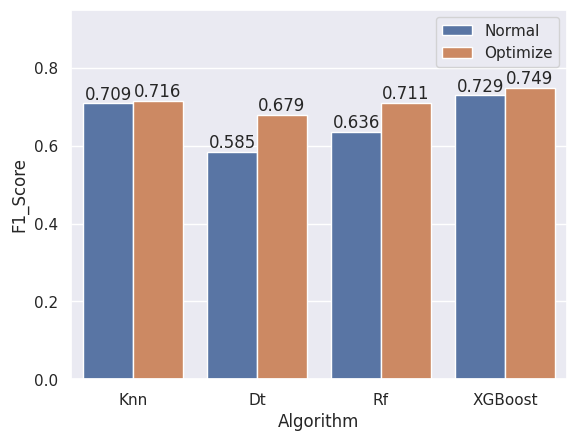

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels_1 = ["Normal"]*4
labels_2 = ["Optimize"]*4
labels_list = labels_1 + labels_2

algos_list = ["Knn", "Dt", "Rf", "XGBoost"]

normal_results = np.array([normal_f1_knn, normal_f1_dt, normal_f1_rf, normal_f1_xgboost])
op_results = - np.array([op_f1_knn["loss"], op_f1_dt["loss"], op_f1_rf["loss"], op_f1_xgboost["loss"]])

final_results = np.append(normal_results, op_results)
final_result_dict = {"result": final_results, "algos": algos_list*2, "Type": labels_list}

df_result = pd.DataFrame(final_result_dict)
sns.set_theme()
plt.ylim(0, 0.95)
ax1 = sns.barplot(data=df_result, x="algos", y="result", hue="Type")
ax1.legend(loc='upper right')
ax1.set_xlabel("Algorithm")
ax1.set_ylabel("F1_Score")

for p in ax1.patches:
    ax1.annotate(format(p.get_height(), ".3f"),
                 (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom')

plt.show();

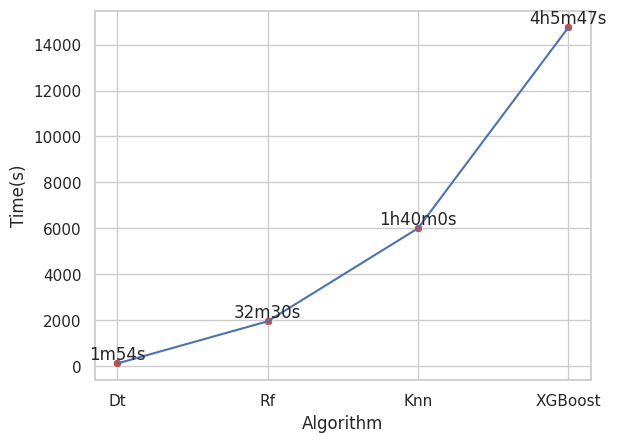

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

algos_list = ["Knn", "Dt", "Rf", "XGBoost"]
time_list = [execution_time_op_knn, execution_time_op_dt, execution_time_op_rf, execution_time_op_xgboost]

sorted_indices = np.argsort(time_list)
sorted_time = np.array(time_list)[sorted_indices]
sorted_algos = np.array(algos_list)[sorted_indices]

time_formatted = []
for t in sorted_time:
    minutes = int(t // 60)
    seconds = int(t % 60)
    if minutes >= 60:
      hours = int(minutes // 60)
      minutes = int(minutes % 60)
      time_str = f"{hours}h{minutes}m{seconds}s"
    else:
      time_str = f"{minutes}m{seconds}s"
    time_formatted.append(time_str)

time_dict = {"time": sorted_time, "algos": sorted_algos}

sns.set_theme(style="whitegrid")
ax = sns.scatterplot(data=time_dict, x="algos", y="time", color="r")
sns.lineplot(data=time_dict, x="algos", y="time")
ax.set_xlabel("Algorithm")
ax.set_ylabel("Time(s)")

for i, time in enumerate(time_formatted):
    ax.text(i, sorted_time[i], time, ha="center", va="bottom")

plt.show()
